In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files # Import the files module for uploading

In [18]:
print("Please upload your document image:")
uploaded = files.upload()

Please upload your document image:


In [13]:
# Get the filename of the single uploaded file
image_path = list(uploaded.keys())[0]
# Read the uploaded image
image = cv2.imread(image_path)
original_image = image.copy() # Keep a copy for the final step


In [14]:
# --- Step 2: Edge Detection ---
print("\nSTEP 2: Detecting Edges...")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)


STEP 2: Detecting Edges...


In [15]:
# --- Step 3: Find Document Contour ---
print("STEP 3: Finding the document contour...")
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
screenCnt = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        screenCnt = approx
        break

if screenCnt is None:
    raise Exception("Could not find a 4-sided contour. Try a different image or adjust Canny thresholds.")
# Draw the found contour for visualization
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)

STEP 3: Finding the document contour...


array([[[ 4,  7,  6],
        [ 5,  7,  5],
        [ 5,  6,  3],
        ...,
        [97, 97, 96],
        [97, 97, 97],
        [97, 97, 97]],

       [[ 4,  6,  5],
        [ 6,  8,  4],
        [ 6,  6,  5],
        ...,
        [97, 97, 97],
        [97, 97, 97],
        [97, 97, 97]],

       [[ 5,  8,  6],
        [ 7,  7,  6],
        [ 7,  5,  6],
        ...,
        [97, 97, 97],
        [97, 97, 97],
        [97, 97, 97]],

       ...,

       [[27, 26, 24],
        [27, 26, 24],
        [27, 26, 24],
        ...,
        [27, 26, 24],
        [27, 26, 24],
        [27, 26, 24]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [16]:
# --- Step 4: Apply Perspective Transform ---
print("STEP 4: Applying perspective transform...")
pts = screenCnt.reshape(4, 2)
rect = np.zeros((4, 2), dtype="float32")

s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]
diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]

(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))

dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype="float32")

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(original_image, M, (maxWidth, maxHeight))


STEP 4: Applying perspective transform...


STEP 5: Displaying results...


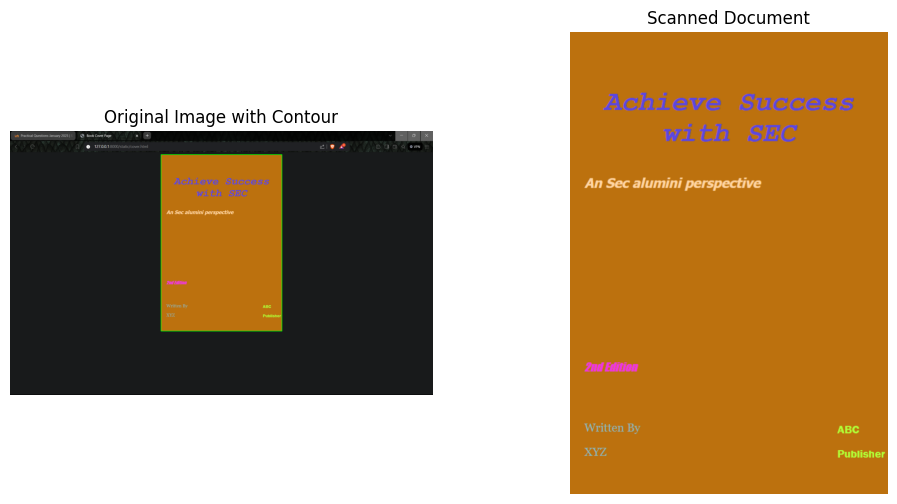

In [17]:
# --- Step 5: Display the Results ---
print("STEP 5: Displaying results...")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Contour')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Scanned Document')
plt.axis('off')

plt.show()